In [2]:
import numpy as np
import pandas as pd
from numba import njit, jit

from math import log, sqrt, pi, exp, erf, ceil, floor
from scipy.stats import norm

from matplotlib import pyplot as plt
from tqdm import tqdm
from time import perf_counter
import gc

""" API requirements """
import pandas as pd
import yfinance as yf

""" Plt font size """
plt.rcParams['font.size'] = '15'
plt.rcParams["figure.figsize"] = (20, 7)
plt.style.use('bmh')

""" Force Numpy and Pandas to print floating format with 5 decimal places"""
np.set_printoptions(suppress=True, precision=5)
pd.set_option("display.precision", 5)

# Question 1

------------------------------------------------------------------------------------------------------------------------
## Calculate T
Count how many trading days until 6 months from now and devide by 252

In [3]:
import pandas_market_calendars as mcal
import datetime as dt
# Create a calendar
nyse = mcal.get_calendar('NYSE')

# Show available calendars
# print(mcal.get_calendar_names())
NOW     = dt.datetime.now() # OR 
NOW     = dt.datetime(year=2023, month=3, day=10)
_END    = NOW+dt.timedelta(days=ceil(365/2))
calendar        = nyse.schedule(start_date=NOW, end_date=_END)
expiration_date = pd.to_datetime(calendar.index.values[-1])

T = calendar.shape[0]

print(f"Expiration Date = {pd.to_datetime(expiration_date).strftime('%Y-%m-%d')}")
print(f"Trading Days until expiration = {T} / 252") ; T = T / 252
print(f"T = {T}")
# early

Expiration Date = 2023-09-08
Trading Days until expiration = 126 / 252
T = 0.5


## Calculate R

In [4]:
""" Treasury Bill : TMUBMUSD06M 
site: https://www.wsj.com/market-data/quotes/bond/BX/TMUBMUSD06M
value: 5.148% """

r = 0.05148
R = np.log(1 + r)

print(f"Annualized return = {r}")
print(f'Cont. Comp return = {R:.5f}')

Annualized return = 0.05148
Cont. Comp return = 0.05020


## Calculate S0
### Get Historical Stock Data from Yahoo Finance

In [5]:
aapl = yf.Ticker("AAPL")

In [6]:
""" Get historical market data """
_START  = NOW-dt.timedelta(days=ceil(365/2))
hist    = aapl.history(start=_START, end=NOW)
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-09-07,154.32798,156.17209,153.12182,155.46436,87449600,0.0,0
2022-09-08,154.14854,155.86307,152.19476,153.96912,84923800,0.0,0
2022-09-09,154.97590,157.31844,154.25819,156.86986,68028800,0.0,0
2022-09-12,159.08281,163.73796,158.79373,162.91060,104956000,0.0,0
2022-09-13,159.39181,160.02978,152.88257,153.35107,122656600,0.0,0
...,...,...,...,...,...,...,...
2023-03-01,146.83000,147.23000,145.00999,145.31000,55479000,0.0,0
2023-03-02,144.38000,146.71001,143.89999,145.91000,52238100,0.0,0
2023-03-03,148.03999,151.11000,147.33000,151.03000,70668500,0.0,0


### Calculate S0 from the last Closing Price - daily Interval

In [7]:
""" Closing Price - S0 """
S0 = hist.iloc[-1].Close ; print(f'S0 = {S0:.5f}')

S0 = 152.41000


## Calculate SIGMA - Historical Volatility

Historical Volatility the last 6 months using different methods for calculating Volatility

Std(log(returns)): 
>> 0.022715021

Parkinson volatility: 
>> 0.017989066

Rogers and Satchell Volatility: 
>> 0.017225886


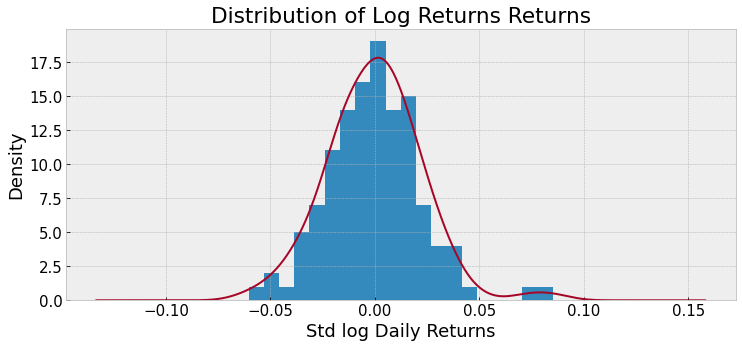

In [24]:
from numpy import log as ln
""" Std of the log of daily returns """
hist['prChange'] = hist.Close.pct_change()
hist['log_ret'] = np.log(1 + hist.prChange)
print("Historical Volatility the last 6 months using different methods for calculating Volatility\n")

""" Std of Log Returns for the last 6 months """
SIGMA = hist.loc[hist.index > _START].log_ret.std(ddof=1)
print(f'Std(log(returns)): \n>> {SIGMA:.9f}\n')

""" Parkinson Volatility Model """
sum_squared_log_HL = ((np.log((hist.High / hist.Low)))**2 ).loc[hist.index > _START]
parkinson_historical_volatility_last_6_months = np.sqrt( 1/(4*(sum_squared_log_HL.shape[0]-1)*np.log(2)) * sum_squared_log_HL.sum() )
print(f'Parkinson volatility: \n>> {parkinson_historical_volatility_last_6_months:.9f}\n')

""" Rogers and Satchell Volatility Function """
data = hist.loc[hist.index > _START]
daily_rs_sqr_vol = (ln(data.High/data.Open)*(ln(data.High/data.Close))) \
         + ln(data.Low/data.Open)*( ln(data.Low/data.Close))
rs_vol = np.sqrt(daily_rs_sqr_vol.mean())
print(f'Rogers and Satchell Volatility: \n>> {rs_vol:.9f}')

ax = hist.loc[hist.index > _START].log_ret.hist(bins=20)
ax = hist.loc[hist.index > _START].log_ret.plot(kind='kde', title='Distribution of Log Returns Returns', figsize=(12,5))
plt.xlabel('Std log Daily Returns') ; plt.show()


## Calculate K

Get available expiration dates for available options' - and find option closer to the current

In [9]:
""" Available Dates """
options_list = aapl.options
print('Available Expiration Dates: ', options_list)

""" Find Nearest to 6 months """
indx_of_closest_to_6M = np.argmin(np.abs(pd.to_datetime(options_list) - _END))
print(f'>>Expiration Date closest to the 6 months: {options_list[indx_of_closest_to_6M]}')

Available Expiration Dates:  ('2023-03-10', '2023-03-17', '2023-03-24', '2023-03-31', '2023-04-06', '2023-04-14', '2023-04-21', '2023-05-19', '2023-06-16', '2023-07-21', '2023-08-18', '2023-09-15', '2023-10-20', '2023-12-15', '2024-01-19', '2024-03-15', '2024-06-21', '2024-09-20', '2025-01-17', '2025-06-20', '2025-12-19')
>>Expiration Date closest to the 6 months: 2023-09-15


In [10]:
""" Put Options ~ 6 Months from now """
opt = aapl.option_chain(options_list[ indx_of_closest_to_6M])
opt_puts = opt.puts
opt_puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL230915P00065000,2023-03-06 17:34:52+00:00,65.0,0.10,0.11,0.12,0.00,0.00000,4,156,0.50001,False,REGULAR,USD
1,AAPL230915P00070000,2023-03-06 20:38:00+00:00,70.0,0.15,0.16,0.18,0.00,0.00000,1,7866,0.48780,False,REGULAR,USD
2,AAPL230915P00075000,2023-03-06 17:43:14+00:00,75.0,0.21,0.21,0.23,0.00,0.00000,1,4690,0.46436,False,REGULAR,USD
3,AAPL230915P00080000,2023-03-07 14:59:44+00:00,80.0,0.28,0.28,0.30,0.01,3.70370,25,1717,0.44336,False,REGULAR,USD
4,AAPL230915P00085000,2023-03-07 14:43:43+00:00,85.0,0.37,0.37,0.39,0.02,5.71429,5,2899,0.42383,False,REGULAR,USD
5,AAPL230915P00090000,2023-03-06 16:04:04+00:00,90.0,0.44,0.50,0.53,0.00,0.00000,75,3156,0.40919,False,REGULAR,USD
6,AAPL230915P00095000,2023-03-06 20:46:14+00:00,95.0,0.62,0.66,0.69,0.00,0.00000,19,3187,0.39234,False,REGULAR,USD
7,AAPL230915P00100000,2023-03-07 14:56:36+00:00,100.0,0.83,0.85,0.88,0.03,3.75000,23,24434,0.37476,False,REGULAR,USD
8,AAPL230915P00105000,2023-03-06 20:47:54+00:00,105.0,1.04,1.13,1.16,0.00,0.00000,26,10501,0.36121,False,REGULAR,USD
9,AAPL230915P00110000,2023-03-07 15:01:52+00:00,110.0,1.47,1.47,1.51,0.12,8.88889,2,3203,0.34754,False,REGULAR,USD


In [25]:
""" From that list, puts ~ at the money """
_tempdf = opt_puts[opt_puts.inTheMoney == True]
option_at_the_money = _tempdf.iloc[(_tempdf['strike'] - S0 ).abs().argsort()[:1]]

K  = option_at_the_money.strike.iloc[0]
P0 = option_at_the_money.lastPrice.iloc[0]

""" Local Variables for consistency across calculations - Comment out for getting live data"""
S0 = 153.8 #USD 
K  = 155.0 #USD
P0 = 11.2  #USD

""" Return K and P Used """
print(f"S0 = {S0:.1f} USD \nK  = {K} USD")
print(f"P0 = {P0}  USD <-- Asking Price for a put option with these parameters")

option_at_the_money

S0 = 153.8 USD 
K  = 155.0 USD
P0 = 11.2  USD <-- Asking Price for a put option with these parameters


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
18,AAPL230915P00155000,2023-03-07 15:07:32+00:00,155.0,12.07,12.0,12.15,0.87,7.76786,22,4946,0.24299,True,REGULAR,USD


# Question 2

-------------------------------------------------------------------------------------------------------------------------------
## Black Sholes Analytical Solution

In [12]:
@njit
def bs_put(S, K, T, r, sigma):
    d1 = (log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)

    """ negative in front - negative in front of d1 """
    D = - (1.0 + erf(-d1 / sqrt(2.0))) / 2.0
    V = S*D + K*exp(-r*T)* (1.0 + erf(-d2 / sqrt(2.0))) / 2.0

    return V

In [13]:
print(f'S0, K, T, R, SIGMA = {S0:.1f}, {K:.1f}, {T:.3f}, {R:.4f}, {SIGMA:.4f}')
black_sholes_put_value = bs_put(S0, K, T, R, SIGMA)
print("------ BS Put Evaluation ------")
print(f'Option Value with Black-Scholes Formula = {black_sholes_put_value:.5f}')

S0, K, T, R, SIGMA = 153.8, 155.0, 0.500, 0.0502, 0.0227
------ BS Put Evaluation ------
Option Value with Black-Scholes Formula = 0.17522


## Binomial Tree - Option Valuation

In [14]:
@njit
def option_valuation_bt(S0, K, T, r, sigma, N, type="Call", american=False, print_tree=False):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt)) 
    d = np.exp(-sigma * np.sqrt(dt)) 
    p = (np.exp(r*dt) - d)/(u - d) 
    """ ----- Build the Tree ----- """
    tree = np.zeros((N + 1, N + 1))
    # Iterate over the lower triangle
    for i in np.arange(N + 1): # iterate over rows
        for j in np.arange(i + 1): # iterate over columns
            tree[i, j] = S0 * d ** (i-j) * u ** (j) 
    if print_tree: print(np.rot90(tree)) 

    """ ----- Calculate the Option Value ----- """
    columns = tree.shape[1]
    rows = tree.shape[0]

    """ Back Propagation: we start in last row of the matrix """

    # Add the payoff function in the last row
    for c in np.arange(columns):
        _S = tree[rows-1, c] # value in the matrix
        if type == "C": tree[rows-1, c] = max(0, _S - K) 
        else: tree[rows-1, c] = max(0, K- _S) 
    # print( tree.astype(int) )

    # For all other rows , we need to combine from previous rows
    # We walk backwards , from the last row to the first row
    for i in np.arange(rows-1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i+1, j]
            up = tree[i + 1, j + 1]
            if type == "Call":
                if american:    tree[i , j ] = max(tree[i , j ]-K, (np.exp(-r*dt)) * (p * up + (1 - p) * down)) 
                else:           tree[i , j ] = (np.exp(-r*dt)) * (p * up + (1 - p) * down) 
            else:
                if american:    tree[i , j ] = max(K-tree[i , j ], (np.exp(-r*dt)) * (p * up + (1 - p) * down)) 
                else:           tree[i , j ] = (np.exp(-r*dt)) * (p * up + (1 - p) * down) 
    if print_tree: print(np.rot90(tree))
    V = tree[0,0]
    """ Greeks """
    D = (tree[1, 1] - tree[1, 0])/(S0 * (u - d))
    return V

In [15]:
# 100, 120, 0.02, 5,.1,1000
# 24.2
# 14.19
# option_valuation_bt(S0=100, K=120, T=5, r=.02, vol=0.1, N=4, type="P", print_tree=0)

In [16]:
N = 1_000

P_bt = option_valuation_bt(S0=S0, K=K, T=T, r=R, sigma=SIGMA, N=N, type="Put", american=True)
print(f'Option Value with N({N}) steps = {P_bt:.5f}')
# print(f'Delta with N({N}) steps        = {Delta_bt:.5f}')

Option Value with N(1000) steps = 1.20000


## Calculate/Plot Option Value Convergence with N (steps)

In [17]:
NN = 10_000 ;   size = 100
values = np.zeros((size, 3))

for n in tqdm(np.append(np.logspace(1, np.log10(NN), size, base=10, dtype=int), 50)): #  _starting_n, NN)):
    # print(n)
    _st = perf_counter()
    P_bt = option_valuation_bt(S0=S0, K=K, T=T, r=R, sigma=SIGMA, N=n, type="Put")
    values[size-1] = n, P_bt, perf_counter() - _st
    size -= 1
values = values[::-1]

100%|██████████| 101/101 [00:04<00:00, 20.23it/s]


,Binary Tree,Execution Time,Black Scholes,|Difference|
10,0.13562,2.20830e-05,0.17522,0.03960
11,0.14631,6.62500e-06,0.17522,0.02891
12,0.13917,7.54200e-06,0.17522,0.03605
13,0.15216,4.66700e-06,0.17522,0.02306
14,0.14134,5.04200e-06,0.17522,0.03388
...,...,...,...,...
7564,0.17515,3.54034e-01,0.17522,0.00007
8111,0.17518,4.12558e-01,0.17522,0.00004
8697,0.17516,4.80424e-01,0.17522,0.00006
9326,0.17519,5.59238e-01,0.17522,0.00003


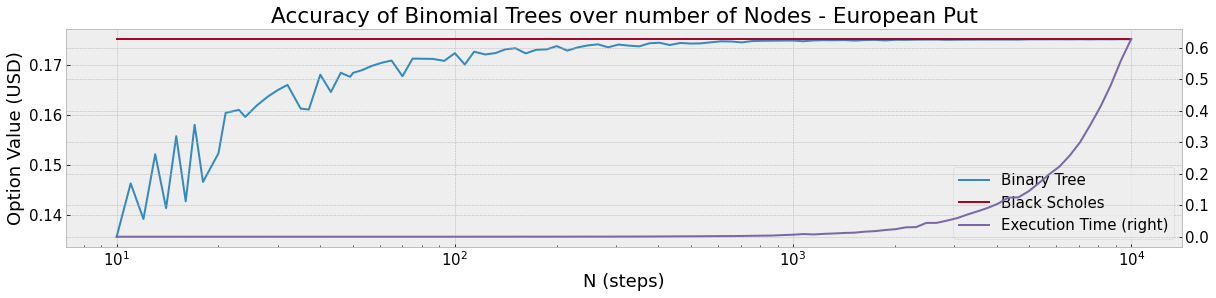

In [18]:

_results_convergence_df = pd.DataFrame(values[:, 1:], columns=['Binary Tree', 'Execution Time'] , index=values[:, 0].astype(int)).sort_index()
_results_convergence_df["Black Scholes"] = black_sholes_put_value
_results_convergence_df["|Difference|"] = abs(_results_convergence_df[['Binary Tree']] - black_sholes_put_value)

_results_convergence_df[['Binary Tree', 'Black Scholes', 'Execution Time']].plot(figsize=(20,4), xlabel='N (steps)', ylabel='Option Value (USD)', mark_right=True,
                              title='Accuracy of Binomial Trees over number of Nodes - European Put', grid=True, logx=True,
                              secondary_y='Execution Time' )
_results_convergence_df

# Question 3

----------------------------------------------------------------------------------------------------------------

## (a) Print 3 step Binomial Tree - American and European

In [19]:
N = 3
print(" American 3-step Binomial Tree")
_ = option_valuation_bt(S0=S0, K=K, T=T, r=R, sigma=SIGMA, N=N, type="Put", american=True,  print_tree=True)

print("\n European 3-step Binomial Tree")
_ = option_valuation_bt(S0=S0, K=K, T=T, r=R, sigma=SIGMA, N=N, type="Put", american=False,  print_tree=True)

 American 3-step Binomial Tree
[[  0.        0.        0.      158.13881]
 [  0.        0.      156.6791  155.23288]
 [  0.      155.23288 153.8     152.38035]
 [153.8     152.38035 150.9738  149.58024]]
[[0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.0587  1.2     2.61965]
 [1.2     2.61965 4.0262  5.41976]]

 European 3-step Binomial Tree
[[  0.        0.        0.      158.13881]
 [  0.        0.      156.6791  155.23288]
 [  0.      155.23288 153.8     152.38035]
 [153.8     152.38035 150.9738  149.58024]]
[[0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.00627 0.12815 2.61965]
 [0.01837 0.25461 2.73481 5.41976]]


## (a) Plot Relative to Time - American vs European

100%|██████████| 100/100 [00:00<00:00, 100.11it/s]


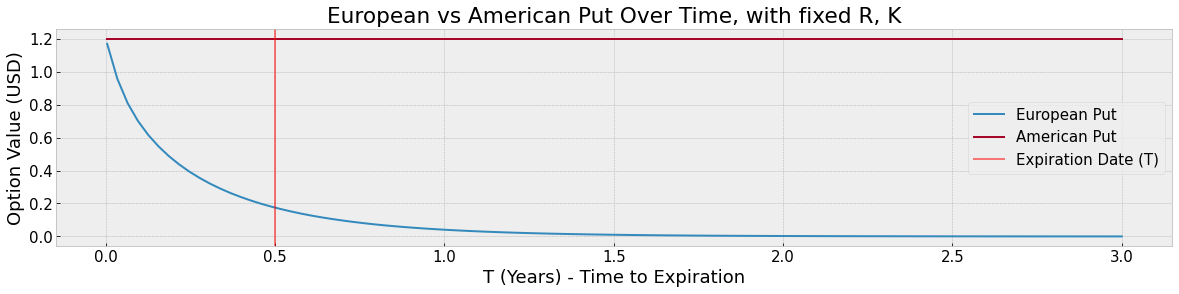

In [29]:
N = 1_000   ;   size = 100  ;   values = np.zeros((size, 3))
for _T in tqdm(np.linspace(1/252, 3, num=size)):
    _P_bt_european = option_valuation_bt(S0=S0, K=K, T=_T, r=R, sigma=SIGMA, N=N, type="Put")
    _P_bt_american = option_valuation_bt(S0=S0, K=K, T=_T, r=R, sigma=SIGMA, N=N, type="Put", american=True)
    values[size-1] = [_T, _P_bt_european, _P_bt_american]
    size -= 1

_results_df = pd.DataFrame(values[:, 1:], columns=['European Put', 'American Put'] , index=values[:, 0]).sort_index()
_results_df

axs = _results_df[['European Put', 'American Put']].plot(figsize=(20,4), xlabel='T (Years) - Time to Expiration', ylabel='Option Value (USD)',
                              title='European vs American Put Over Time, with fixed R, K', grid=True)
axs.axvline(T, color='r', linestyle='-', alpha=.5, label='Expiration Date (T)') ;   axs.legend() ; plt.show()

## (b) Plot Option Value Relative to N - American vs European

100%|██████████| 200/200 [00:17<00:00, 11.15it/s]  

American vs European put
Rel Difference: 1.02
 %  Difference: 585.01 %


European Put    0.17518
American Put    1.20000
Difference      1.02482
Name: 10000.0, dtype: float64

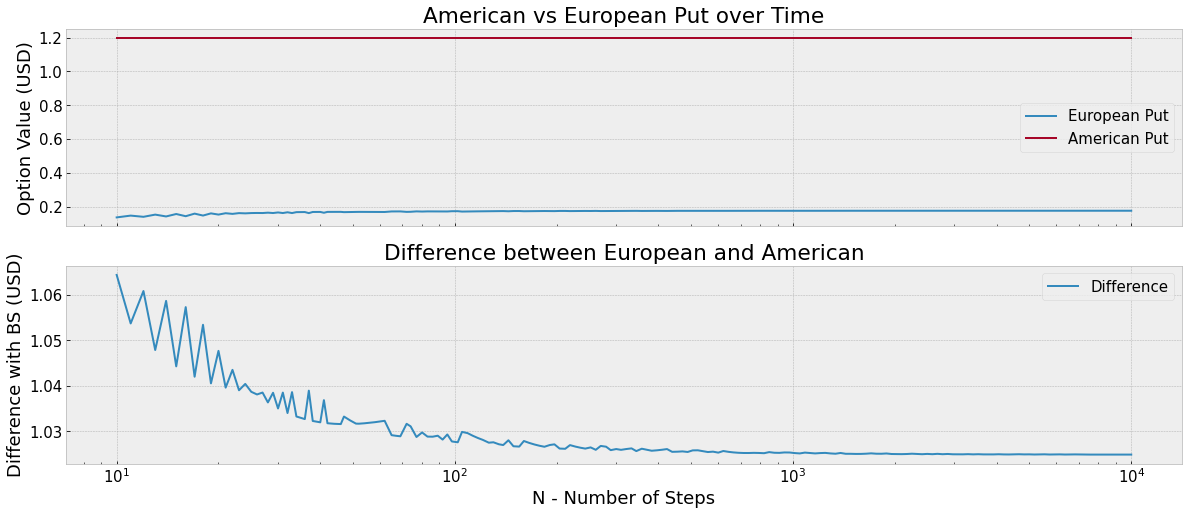

In [26]:
size = 200  ;   values = np.zeros((size, 3))
for n in tqdm(np.logspace(1, 4, num=size, base=10, dtype=int)):
    _P_bt_european = option_valuation_bt(S0=S0, K=K, T=T, r=R, sigma=SIGMA, N=n, type="Put")
    _P_bt_american = option_valuation_bt(S0=S0, K=K, T=T, r=R, sigma=SIGMA, N=n, type="Put", american=True)
    values[size-1] = [n, _P_bt_european, _P_bt_american]
    size -= 1

""" Plot """
_results_df = pd.DataFrame(values[:, 1:], columns=['European Put', 'American Put'] , index=values[:, 0]).sort_index()
_results_df["Difference"] = _results_df[['American Put']].to_numpy() - _results_df[['European Put']].to_numpy()

fig, axs = plt.subplots(2, sharex=True)

_results_df[['European Put', 'American Put']].plot(figsize=(20,8), xlabel='N', ylabel='Option Value (USD)', ax=axs[0],
                              title='American vs European Put over Time', grid=True, logx=True)
_results_df[["Difference"]].plot(figsize=(20,8), xlabel='N - Number of Steps', ylabel='Difference with BS (USD)',  ax=axs[1],
                              title='Difference between European and American', grid=True, logx=True, logy=False)
print('American vs European put')
print(f'Rel Difference: {(_results_df.iloc[-1,1] - _results_df.iloc[-1,0]):.2f}')
print(f' %  Difference: {(_results_df.iloc[-1,1] - _results_df.iloc[-1,0]) / _results_df.iloc[-1,0] *100:.2f} %')
_results_df.iloc[-1]

## (c) Effect of Interest Rates to American and European Puts

Annualized Interest Rate: 5.148%


100%|██████████| 100/100 [00:00<00:00, 7908.86it/s]


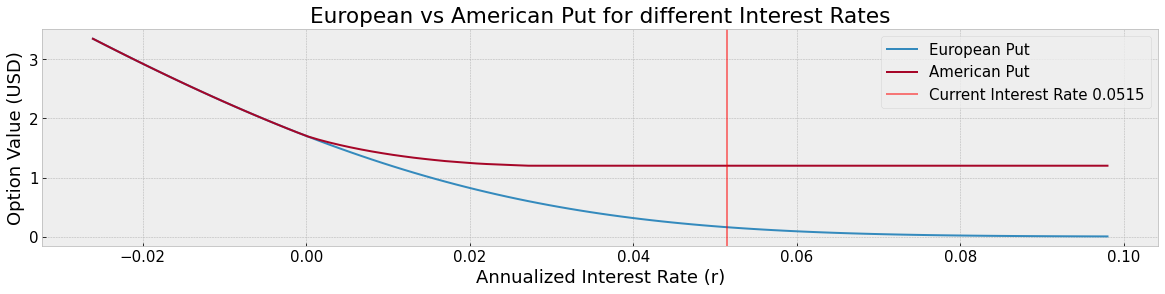

In [22]:
print(f'Annualized Interest Rate: {r*100:.3f}%')
N = 100
size = 100  ;   values = np.zeros((size, 3))
for _r in tqdm(np.linspace(-r/2, r*2, num=size)): 
    _r = np.log(1+ _r) # From annual to CCIR
    _V_bt_european = option_valuation_bt(S0=S0, K=K, T=T, r=_r, sigma=SIGMA, N=N, type="P")
    _V_bt_american = option_valuation_bt(S0=S0, K=K, T=T, r=_r, sigma=SIGMA, N=N, type="P", american=True)
    values[size-1] = [_r, _V_bt_european, _V_bt_american]
    size -= 1

""" Plot """
_results_df = pd.DataFrame(values[:, 1:], columns=['European Put', 'American Put'] , index=values[:, 0]).sort_index()
axs = _results_df[['European Put', 'American Put']].plot(figsize=(20,4), xlabel='Annualized Interest Rate (r)', ylabel='Option Value (USD)',title='European vs American Put for different Interest Rates', grid=True)
axs.axvline(r, color='r', linestyle='-', alpha=.5, label=f'Current Interest Rate {r:.4f}') ;   axs.legend() ; plt.show()

## (c) Calculate Expected Difference with European Put Using Analytical Solution for European Put

In [23]:
def calculate_SE():
    size = 11   ;   _N = 2_000
    _results_se = np.empty((size, 3))  ;   index = 0
    for _coef in np.linspace(-1, 1, num=size):
        _sigma = SIGMA * (10**_coef)
        _results_se[index, 0] = _sigma
        _results_se[index, 1] = _coef
        _results_se[index, 2] = (option_valuation_bt(S0=S0, K=K, T=T, r=_r, sigma=SIGMA, N=N, type="P", american=True) -
                                 bs_put(S0, K, T, R, _sigma)) / bs_put(S0, K, T, R, _sigma) * 100
        index += 1
    return _results_se
_results_se = calculate_SE()
# _results_se

ZeroDivisionError: float division by zero

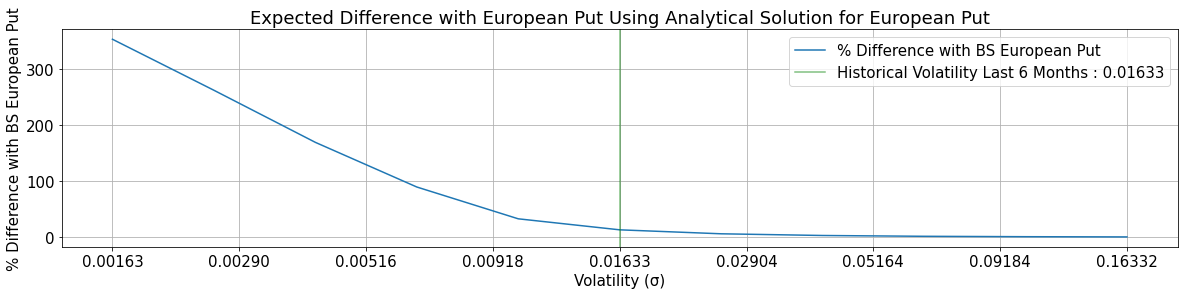

In [ ]:
_results_se_df = pd.DataFrame(_results_se[:, 1:], columns=['Volatility (σ)','% Difference with BS European Put'])
_results_se_df.set_index("Volatility (σ)", inplace=True)

ax = _results_se_df.plot(figsize=(20,4), grid=True, ylabel='% Difference with BS European Put', title="Expected Difference with European Put Using Analytical Solution for European Put")
ax.axvline(0, color='g', linestyle='-', alpha=.5, label=f'Historical Volatility Last 6 Months : {SIGMA:.5f}')   ;   ax.legend()

plt.xticks(plt.xticks()[0][1:-1], [f'{SIGMA * (10**x):.5f}' for x in plt.xticks()[0][1:-1]])    ;   print()

# 3D Graphs -> Visualize the relationship between a Put Option's Value (P) and the Strike Price (K) and Volatility (SIGMA)

In [ ]:
import multiprocessing
from joblib import Parallel, delayed
gc.collect()

""" Simulation Parameters """
N = 2_000    ;    total_points = 900  ;    print(f'Total Steps Calculated (N) = {N*total_points}') # points should be [2500, 900]

start_sigma = 0.001  ;   end_sigma = .2 # * realized_volatility_last_6_months
start_K = 0.8 * S0  ;   end_K = 1.2 * S0

""" Prepare Input """
size_of_graph = np.sqrt(total_points).astype(int)   # points should be [2500, 900]
V_values = np.logspace(np.log10(start_sigma), np.log10(end_sigma), size_of_graph, base=10)
# V_values = np.linspace(start_sigma, end_sigma, size_of_graph)
K_values = np.linspace(start_K, end_K, size_of_graph, dtype=int)

input_matrix = np.empty((0, 2))
for _sigma in V_values:
    for _K in K_values:
        input_matrix = np.append(input_matrix, np.array([[_sigma, _K]]), axis=0)

inputs = tqdm(input_matrix)

""" Define function that calculates """
def simulate(input_matrix):
    v = option_valuation_bt(T=.53, r=0.006 , K=input_matrix[1], vol=input_matrix[0], N=N, S0=S0 ,type="P", american=True)
    return np.array([np.log10(input_matrix[0]), input_matrix[1], v])
    # return np.array([input_matrix[0], input_matrix[1], v])

""" Run Parallel Simulation """
num_cores = multiprocessing.cpu_count()
temp_output = Parallel(n_jobs=num_cores)(delayed(simulate)(row) for row in inputs)
""" Revert back to matrix form"""
# print(temp_output)
result_3D = np.empty((0, 3))
for array in temp_output:
    result_3D = np.append(result_3D, [array], axis=0)
result_3D

Total Steps Calculated (N) = 1800000


100%|██████████| 900/900 [00:09<00:00, 99.41it/s] 


array([[ -3.        , 127.        ,   0.        ],
       [ -3.        , 129.        ,   0.        ],
       [ -3.        , 131.        ,   0.        ],
       ...,
       [ -0.69897   , 186.        ,  28.18401248],
       [ -0.69897   , 188.        ,  29.94488647],
       [ -0.69897   , 191.        ,  32.63982596]])

159.3000030517578

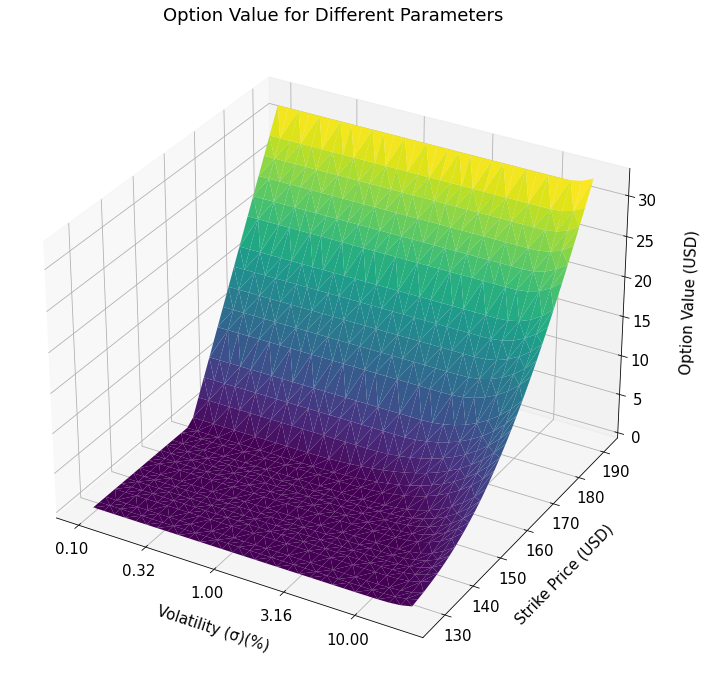

In [ ]:
plt.rcParams['font.size'] = '15'

fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')
ax.plot_trisurf(result_3D[:, 0], result_3D[:, 1], result_3D[:, 2], cmap='viridis', edgecolor='none')  # 'viridis' , cm.jet

plt.xticks(plt.xticks()[0][1:-1], [f'{10**x*100:.2f}' for x in plt.xticks()[0][1:-1]])

ax.set_ylabel('\n\nStrike Price (USD)')   ;   ax.set_xlabel('\n\nVolatility (σ)(%)')   ;   ax.set_zlabel('\n\n\nOption Value (USD)')
ax.dist = 10
ax.set_title("Option Value for Different Parameters")
S0

In [ ]:
import multiprocessing
from joblib import Parallel, delayed
gc.collect()

""" Simulation Parameters """
N = 2_000    ;    total_points = 900  ;    print(f'Total Steps Calculated (N) = {N*total_points}') # points should be [2500, 900]

start_sigma = 0.001  ;   end_sigma = .2 # * realized_volatility_last_6_months
start_T = 1/253 ;   end_T = 3

""" Prepare Input """
size_of_graph = np.sqrt(total_points).astype(int)   # points should be [2500, 900]
V_values = np.logspace(np.log10(start_sigma), np.log10(end_sigma), size_of_graph, base=10)
# V_values = np.linspace(start_sigma, end_sigma, size_of_graph)
T_values = np.linspace(start_T, end_T, size_of_graph, dtype=int)

input_matrix = np.empty((0, 2))
for _sigma in V_values:
    for _T in T_values:
        input_matrix = np.append(input_matrix, np.array([[_sigma, _T]]), axis=0)

inputs = tqdm(input_matrix)

""" Define function that calculates """
def simulate(input_matrix):
    v = option_valuation_bt(T=_T, r=0.006 , K=K, vol=input_matrix[0], N=N, S0=S0 ,type="P", american=True)
    return np.array([np.log10(input_matrix[0]), input_matrix[1], v])
    # return np.array([input_matrix[0], input_matrix[1], v])

""" Run Parallel Simulation """
num_cores = multiprocessing.cpu_count()
temp_output = Parallel(n_jobs=num_cores)(delayed(simulate)(row) for row in inputs)  ;   gc.collect()

""" Revert back to matrix form"""
result_3D = np.empty((0, 3))
for array in temp_output:
    result_3D = np.append(result_3D, [array], axis=0)
# result_3D

Total Steps Calculated (N) = 1800000


100%|██████████| 900/900 [00:10<00:00, 82.39it/s] 


Text(0.5, 0.92, 'Option Value for Different Parameters')

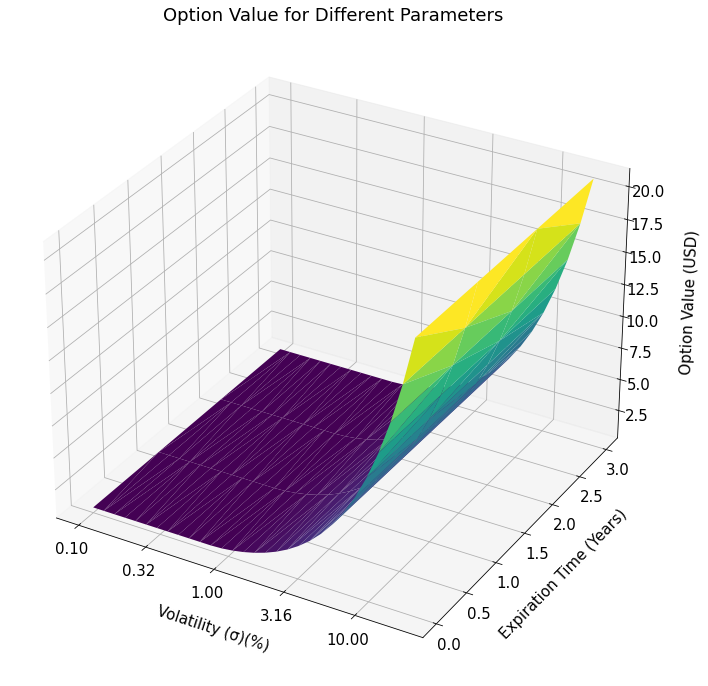

In [ ]:
plt.rcParams['font.size'] = '15'

fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')
ax.plot_trisurf(result_3D[:, 0], result_3D[:, 1], result_3D[:, 2], cmap='viridis', edgecolor='none')  # 'viridis' , cm.jet

plt.xticks(plt.xticks()[0][1:-1], [f'{10**x*100:.2f}' for x in plt.xticks()[0][1:-1]])

ax.set_ylabel('\n\nExpiration Time (Years)')   ;   ax.set_xlabel('\n\nVolatility (σ)(%)')   ;   ax.set_zlabel('\n\n\nOption Value (USD)')
ax.dist = 10
ax.set_title("Option Value for Different Parameters")

# Question 4

---------------------------------------------------------------------------------------------------------------------------------
## Calculate Implied Volatility
Using the bump-and-revalue, gradient algorithm

In [ ]:
""" Choice Number of Steps """
print('-------- Number of steps --------')
print(_results_convergence_df[_results_convergence_df.index > 1000].index.values)

-------- Number of steps --------
[ 1072  1149  1232  1321  1417  1519  1629  1747  1873  2009  2154  2310
  2477  2656  2848  3053  3274  3511  3764  4037  4328  4641  4977  5336
  5722  6135  6579  7054  7564  8111  8697  9326 10000]


In [ ]:
N = 5336
Approximation_Error = abs(_results_convergence_df[_results_convergence_df.index == N][["|Difference|"]].values[0,0])
Approximation_Error

5.435670790915337e-05

## Newtons Mehtod

In [ ]:
ds = 0.08
s0 = .5 ; print(s0)
print(f"Correct Option Value = {P0}")

_V  = option_valuation_bt(S0=S0, K=K, T=T, r=r, sigma=s0, N=N, type="Put", american=True) 
fx  = abs(P0 - _V) ;   _iv_convergence = np.array([[s0, fx]])
print(f"difference in P0 estimation = {fx}")

_st = perf_counter() ; it = 1
while it < 20:
    it += 1
    """ step 1: calculate new Option Values with bumped volatility """
    f_x_plus_ds  = abs(P0 - option_valuation_bt(S0=S0, K=K, T=T, r=r, sigma=s0+ds, N=N, type="Put", american=True))
    f_x_minus_ds  = abs(P0 - option_valuation_bt(S0=S0, K=K, T=T, r=r, sigma=s0-ds, N=N, type="Put", american=True))
    print(f'------------------------------------\nfx = {fx:.4f}, f_x_plus_dx = {f_x_plus_ds:.4f}')

    """ step 2: Calculate slope (a) based on second derivative finate difference """
    fprime  = (f_x_plus_ds - f_x_minus_ds) / 2*ds
    fprime  = (f_x_plus_ds - fx) / ds
    f2prime = (f_x_plus_ds - 2*fx + f_x_minus_ds) / ds**2
    print(f'fprime = {fprime}')
    print(f'f2prime = {f2prime}')
    # s0 = abs(s0 - .5 * fx / fprime)
    s0 = s0 - fx / fprime 

    print(f's0 = {s0}')
    _V = option_valuation_bt(S0=S0, K=K, T=T, r=r, sigma=s0, N=N, type="Put", american=True)
    fx = abs(P0 - _V)
    _iv_convergence = np.append(_iv_convergence, [[s0, fx]], axis=0)
    print(f'Value: {_V}')

    if abs(fx) < 1e-6: break
    
print(f"Time to Calculate = {perf_counter() - _st:.7f}")
IV = s0

0.5
Correct Option Value = 11.2
difference in P0 estimation = 9.222379494557082
------------------------------------
fx = 9.2224, f_x_plus_dx = 12.5975
fprime = 42.1891435359123
f2prime = -1.990309545517599
s0 = 0.2814039650578165
Value: 11.154185442947472
------------------------------------
fx = 0.0458, f_x_plus_dx = 3.3489
fprime = 41.28824942253757
f2prime = 1044.992437275592
s0 = 0.28029433804060716
Value: 11.107127707290424
------------------------------------
fx = 0.0929, f_x_plus_dx = 3.3018
fprime = 40.111445805027614
f2prime = 1030.233102848719
s0 = 0.2779789816418125
Value: 11.008942100651858
------------------------------------
fx = 0.1911, f_x_plus_dx = 3.2035
fprime = 37.65596341142861
f2prime = 999.4272879579089
s0 = 0.272905206280905
Value: 10.793809657560324
------------------------------------
fx = 0.4062, f_x_plus_dx = 2.9882
fprime = 32.275370998751704
f2prime = 931.9099599981731
s0 = 0.26032005760963534
Value: 10.260376794387923
------------------------------------

In [ ]:
s = np.linspace(-.2,.7,100)
v = [abs(P0 - option_valuation_bt(S0=S0, K=K, T=T, r=r, sigma=_, N=100, type="Put", american=True)) for _ in s]
plt.plot(s,v) ; plt.xlabel(r'$\sigma$ - Volatility') ; plt.ylabel(r'$f(\sigma)=|P_0 - V_{Put}(\sigma)|$') ; plt.title("Function to Minimze for finding sigma - Using Newton's Method")
plt.plot(_iv_convergence[:,0], _iv_convergence[:,1], marker='o')
plt.legend([r'$f(\sigma)=|P_0 - V_{Put}(\sigma)|$', "Newton's Method Path"])
plt.show()

NameError: name 'np' is not defined

In [ ]:
print(f'Implied Volatility = {IV:.5f}  vs  '
      f'Historical Volatility = {SIGMA:.5f}  :  '
      f'Difference = {(IV - SIGMA)/SIGMA * 100 :.3f} %  \n'
      f'>>> Iterations = {it}')

Implied Volatility = 0.28248  vs  Historical Volatility = 0.02279  :  Difference = 1139.333 %  
>>> Iterations = 10


In [ ]:
""" History which the Algorithm converges to the implied volatility """
_iv_convergence

array([[ 0.02279, 10.     ],
       [ 0.41063,  5.43705],
       [ 0.34652,  2.71742],
       [ 0.31451,  1.35858],
       [ 0.2985 ,  0.6794 ],
       [ 0.2905 ,  0.33978],
       [ 0.28649,  0.16993],
       [ 0.28449,  0.08499],
       [ 0.28349,  0.0425 ],
       [ 0.28299,  0.02126],
       [ 0.28273,  0.01063],
       [ 0.28261,  0.00532],
       [ 0.28255,  0.00266],
       [ 0.28252,  0.00133],
       [ 0.2825 ,  0.00067],
       [ 0.28249,  0.00033],
       [ 0.28249,  0.00017],
       [ 0.28249,  0.00008],
       [ 0.28249,  0.00004],
       [ 0.28248,  0.00002]])